# A Wright-Fisher simulation implemented in C++ via Cython.

This tutorial implements a Wright-Fisher simulation with mutation and recombination using [Cython](http://www.cython.org).  Cython is two things:

* A grammer/dialect of Python that allows static typing Python and of C/C++ types.
* A static compiler to turn the Cython grammer in to C or C++ code to compile into a Python extension module.

Cython has a learning curve of its own. A lot of what is shown below reflects best practices.  For those, we refer you to the Cython documentation.

Here, we avoid all use of [numpy](http://www.numpy.org) until we have to talk to [msprime](http://msprime.readthedocs.io).  We replace all numpy functionality with the equivalent routines from the excellent GNU Scientific Library, or [GSL](https://www.gnu.org/software/gsl/doc/html/index.html). Yes, numpy is fast!  Numpy is written in C!  But, numpy has to talk back and forth to Python, meaning we can out-perform it by writing routines that execute completely on the C side.

This example is closer to reality for those working in lower-level languages.  First, we must build our world, which means defining data types (structs, in this case), functions acting on those types, and a bunch of auxillary code to manage memory and handle errors.  After all that, we can code up the `simplify` and `evolve` functions. Such is the price of speed.

First, we load an extension allowing us to write Cython in a notebook:

In [1]:
%load_ext Cython
# Set ourselves up for some plotting, too
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
%%cython --cplus --compile-args=-std=c++11 -3 -lgsl -lgslcblas -lm

import msprime
import numpy as np
import struct
cimport numpy as np
from cython.operator cimport dereference as deref
from libc.stdint cimport int32_t, uint32_t
from libcpp.vector cimport vector
from libcpp.unordered_set cimport unordered_set
from libcpp.utility cimport pair
from cython_gsl.gsl_rng cimport *

# Cython doesn't export all of C++'s standard library,
# so we have to expose a few things we need:
cdef extern from "<algorithm>" namespace "std" nogil:
    Iter find[Iter,ValueType](Iter begin, Iter end, const ValueType & value)
    Iter max_element[Iter](Iter begin, Iter end)
    
cdef cppclass TableData:
    # Node data:
    vector[double] time
    # Edge data
    vector[int32_t] parent, child
    vector[double] left, right
    # Mutation data
    vector[int32_t] node, generation
    
    TableData():
        time.reserve(10000)
        parent.reserve(10000)
        child.reserve(10000)
        left.reserve(10000)
        right.reserve(10000)
        node.reserve(10000)
        generation.reserve(10000)
        
    void clear():
        time.clear()
        parent.clear()
        child.clear()
        left.clear()
        right.clear()
        node.clear()
        
cdef pair[int32_t, int32_t] pick_parents(const gsl_rng *r, const int32_t N, const int32_t first_parental_index):
    cdef pair[int32_t, int32_t] rv
    cdef int32_t p = <int32_t>gsl_ran_flat(r,0.0,<double>N)
    
    rv.first = first_parental_index + 2*p
    rv.second = rv.first+1
    # "Mendel"
    if gsl_rng_uniform(r) < 0.5:
        rv.first, rv.second = rv.second, rv.first
    return rv
        
cdef void simplify(TableData & tables, object nodes, object edges, const double dt):
    nodes.set_columns(time=nodes.time+dt,flags=nodes.flags)
    
    # Reverse new node times and add to nodes
    cdef mtime = deref(max_element(tables.time.begin(),tables.time.end()))
    #cdef double mtime = deref(mitr)
    cdef size_t index=0
    for index in range(tables.time.size()):
        tables.time[index]=-1.0*(tables.time[index]-mtime)
    nodes.append_columns(time=np.asarray(<double[:tables.time.size()]>tables.time.data()),
                        flags=np.ones(tables.time.size(),dtype=np.uint32))
    
    edges.append_columns(left=np.asarray(<double[:tables.left.size()]>tables.left.data()),
                        right=np.asarray(<double[:tables.right.size()]>tables.right.data()),
                        parent=np.asarray(<int32_t[:tables.parent.size()]>tables.parent.data()),
                        child=np.asarray(<int32_t[:tables.child.size()]>tables.child.data()))
    samples=np.where(nodes.time==0.0)[0]
    msprime.sort_tables(nodes=nodes,edges=edges)
    msprime.simplify_tables(samples=samples.tolist(),
                           nodes=nodes,
                           edges=edges)
    tables.clear()
    
    
def evolve(int N, int ngens, double theta, double rho, int gc, int seed):
    nodes = msprime.NodeTable()
    nodes.set_columns(time=np.zeros(2*N),flags=np.ones(2*N,dtype=np.uint32))
    edges = msprime.EdgeTable()
    sites = msprime.SiteTable()
    mutations = msprime.MutationTable()
    
    
    cdef TableData tables
    cdef unordered_set[double] mutlookup
    cdef gsl_rng * r = gsl_rng_alloc(gsl_rng_mt19937)
    gsl_rng_set(r,seed)
    cdef size_t generation=0,offspring=0
    cdef int32_t next_offspring_index = 2*N #Same as len(nodes)
    cdef int32_t first_parental_index = 0
    
    for generation in range(ngens):
        for offspring in range(N):
            parents1 = pick_parents(r,N,first_parental_index)
            parents2 = pick_parents(r,N,first_parental_index)
            tables.time.push_back(generation+1.0)
            tables.time.push_back(generation+1.0)
            tables.left.push_back(0.0)
            tables.right.push_back(1.0)
            tables.parent.push_back(parents1.first)
            tables.child.push_back(next_offspring_index)
            tables.left.push_back(0.0)
            tables.right.push_back(1.0)
            tables.parent.push_back(parents2.first)
            tables.child.push_back(next_offspring_index+1)
            next_offspring_index += 2
        first_parental_index = next_offspring_index - 2*N
        
    simplify(tables,nodes,edges,ngens)
    gsl_rng_free(r)
    
    return msprime.load_tables(nodes=nodes,edges=edges)

In [3]:
%%time
evolve(1000,20000,0,0,0,42)

CPU times: user 12.1 s, sys: 3.77 s, total: 15.9 s
Wall time: 15.9 s


# Comparison to msprime

In this section, we compare the distribution of outputs to msprime using [pylibseq](https://github.com/molpopgen/pylibseq), a Python interface to [libsequence](http://molpopgen.github.io/libsequence/)

In [4]:
from IPython.display import SVG
import msprime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from libsequence.polytable import SimData
from libsequence.summstats import PolySIM
from libsequence.msprime import make_SimData
import concurrent.futures
import pandas as pd
from collections import namedtuple

SummStats=namedtuple('SummStats',['S','pi','D','hprime','rmin'])

Let's take a quick tour of pylibseq:

In [5]:
# Simulate data with msprime
ts = msprime.simulate(10,mutation_rate=1,random_seed=666)

# Get it into the format expected by pylibseq
d = make_SimData(ts)

# This should look familiar! :)
print(d)

//
segsites: 10
positions: 0.26833 0.290974 0.325691 0.349762 0.369596 0.390163 0.583813 0.743047 0.767412 0.978347
0100100100
1000010000
0010001000
0100100100
0001100100
0000100101
0000100110
1000010000
1000010000
0100100100


In [6]:
# Create object to calculate summary stats
x = PolySIM(d)
# Calculate a few:
print(x.thetapi(),x.tajimasd(),x.hprime(),x.rm())

3.4666666666666672 -0.08550572842849505 0.5368222463065044 0


In [7]:
%%time
msprime_raw_data=[]
for i in msprime.simulate(10,mutation_rate=100.0/4.0,
                          recombination_rate=0.0,
                          num_replicates=1000,
                          random_seed=42):
    d = make_SimData(i)
    ps = PolySIM(d)
    # A little check that the two pieces of code agree
    assert(ps.numpoly() == i.num_mutations)
    msprime_raw_data.append(SummStats(ps.numpoly(),
                                      ps.thetapi(),ps.tajimasd(),
                                      ps.hprime(),ps.rm()))

CPU times: user 5.15 s, sys: 7.91 ms, total: 5.15 s
Wall time: 5.15 s


To run the forward simulations, we will use multiple Python processes via Python 3's [`concurrent.futures`](https://docs.python.org/3/library/concurrent.futures.html) library. The short of it is that we need a Python function to send out to different processes and return results, which will be pickled into a future back in the main process.

In [8]:
def run_forward_sim(nreps,seed,repid):
    """
    Run our forward sim, calculate
    a bunch of stats, and return 
    the list.
    """
    # Not the best seeding scheme, 
    # but good enough for now...
    np.random.seed(seed)
    msp_rng = msprime.RandomGenerator(int(seed))
    seeds = np.random.randint(0,1000000,nreps)
    sims = []
    for i in range(nreps):
        # print('inputs:',repid,seeds[i])
        ts = evolve(500,10000,0.0,0.0,500,seeds[i])
        samples = np.random.choice(1000,10,replace=False)
        assert(all(ts.tables.nodes.time[samples]==0.0))
        ts2 = ts.simplify(samples=samples.tolist())
        n=msprime.NodeTable()
        e=msprime.EdgeTable()
        s=msprime.SiteTable()
        m=msprime.MutationTable()
        ts2.dump_tables(nodes=n,edges=e)
        # print(n.time.max())
        mutgen = msprime.MutationGenerator(
            msp_rng, 100.0/(float(4*500)))
        mutgen.generate(n,e,s,m)
        ts2=msprime.load_tables(nodes=n,edges=e,sites=s,mutations=m)
        # print(samples)
        # print(n.time[samples])
        # print(s)
        # print(m)
        # Simplify from entire pop down
        # to random sample of n << 2N
        # slist = samples.tolist()
        # slist.append(8)
        # ts2=ts.simplify(slist)
        # print(ts2.num_mutations)
        # print(len(ts2.tables.nodes),
        #      len(ts2.tables.edges),
        #      len(ts2.tables.sites),
        #      len(ts2.tables.mutations))
        d=make_SimData(ts2)
        ps=PolySIM(d)
        sims.append(SummStats(ps.numpoly(),
                              ps.thetapi(),
                              ps.tajimasd(),
                              ps.hprime(),
                              ps.rm()))
    return sims

In [9]:
%%time
x=run_forward_sim(1,66,3511)
print(x)

[SummStats(S=82, pi=20.066666666666645, D=-1.5199598945109298, hprime=-2.8030280056832653, rmin=0)]
CPU times: user 3.02 s, sys: 1.18 s, total: 4.19 s
Wall time: 4.34 s


In the next bit, we map our function into four separate processes.

**Note:** We could use a `concurrent.futures.ThreadPoolExecutor` instead of the process pool executor.  However, some of our Cython functions rely on Python types (`list`, `dict`, etc.), meaning that the Global Interpreter Lock is a barrier to efficient concurrency.  In practice, we've found it better to take the hit of pickling between processes so that your simulations can run at 100% CPU in different processes.

In [23]:
%%time
fwd_sim_data=[]
np.random.seed(16463623)
with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(run_forward_sim,50,np.random.randint(0,2000000,1)[0],i): i for i in range(4)}
    for fut in concurrent.futures.as_completed(futures):
        fn = fut.result()
        fwd_sim_data.extend(fn)

CPU times: user 11.9 ms, sys: 20.3 ms, total: 32.3 ms
Wall time: 3min 53s


In [24]:
msprime_df = pd.DataFrame(msprime_raw_data)
msprime_df['engine'] = ['msprime']*len(msprime_df.index)
fwd_df = pd.DataFrame(fwd_sim_data)
fwd_df['engine']=['forward']*len(fwd_df)
summstats_df = pd.concat([msprime_df,fwd_df])

/Users/krthornt/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6201: RuntimeWarning: divide by zero encountered in true_divide
  m = (m.astype(float) / db) / m.sum()
/Users/krthornt/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6201: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


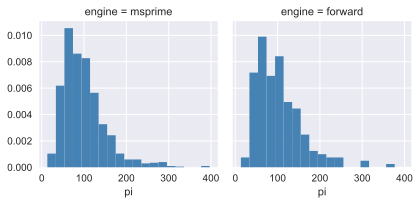

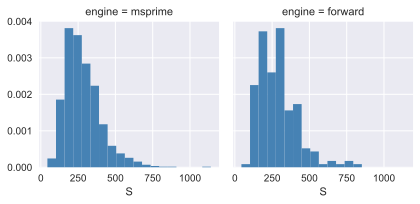

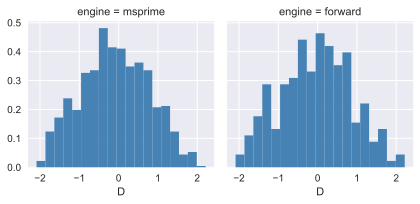

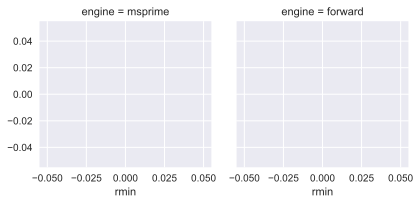

In [25]:
sns.set(style="darkgrid")
g = sns.FacetGrid(summstats_df,col="engine",margin_titles=True)
bins = np.linspace(summstats_df.pi.min(),summstats_df.pi.max(),20)
g.map(plt.hist,'pi',bins=bins,color="steelblue",lw=0,normed=True);

g = sns.FacetGrid(summstats_df,col="engine",margin_titles=True)
bins = np.linspace(summstats_df.S.min(),summstats_df.S.max(),20)
g.map(plt.hist,'S',bins=bins,color="steelblue",lw=0,normed=True);

g = sns.FacetGrid(summstats_df,col="engine",margin_titles=True)
bins = np.linspace(summstats_df.D.min(),summstats_df.D.max(),20)
g.map(plt.hist,'D',bins=bins,color="steelblue",lw=0,normed=True);

g = sns.FacetGrid(summstats_df,col="engine",margin_titles=True)
bins = np.linspace(summstats_df.rmin.min(),summstats_df.rmin.max(),20)
g.map(plt.hist,'rmin',bins=bins,color="steelblue",lw=0,normed=True);

In [26]:
len(fwd_df.index)

200

In [27]:
from scipy.stats import ks_2samp

In [28]:
print(summstats_df.groupby(['engine']).agg(['mean','std']))

               S                      pi                    D            \
            mean         std        mean        std      mean       std   
engine                                                                    
forward  289.315  129.667746  103.023444  55.152992 -0.050817  0.902805   
msprime  282.824  122.831277   99.394289  50.753334 -0.091238  0.858075   

           hprime           rmin       
             mean       std mean  std  
engine                                 
forward  0.091845  0.880910    0  0.0  
msprime  0.143074  0.840379    0  0.0  


The stats are clearly off:

In [29]:
ks_2samp(fwd_df.pi,msprime_df.pi)

Ks_2sampResult(statistic=0.06700000000000006, pvalue=0.43022715543862905)

In [30]:
ks_2samp(fwd_df.S,msprime_df.S)

Ks_2sampResult(statistic=0.051000000000000045, pvalue=0.76848589429374781)

In [31]:
ks_2samp(fwd_df.D,msprime_df.D)

Ks_2sampResult(statistic=0.048000000000000043, pvalue=0.82832436941421084)

In [32]:
ks_2samp(fwd_df.rmin,msprime_df.rmin)

Ks_2sampResult(statistic=0.0, pvalue=1.0)